# Speech Emotion Recognition

The objective of this notebook is to classify from raw sound waves to six emotions: happy, sad, neutral, fear, angry, and disgust. 

1. Gathering data
2. Quick EDA
3. Preprocess
4. Extract features
5. Build a LSTM
6. Evaluate and conclude

Datasets:
* Crowd-sourced Emotional Multimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto Emotional Speech Set (Tessa)

# 1. Gathering data

We will gather speech data from four datasets and store it in a single dataframe along with the corresponding file paths, gender labels and emotion labels. The size of each respective dataframe will be specified, along with an example filename in which the emotion label is bolded. 

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
RAVDESS = "./kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "./kaggle/input/cremad/AudioWAV/"
TESS = "./kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "./kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [3]:
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,./kaggle/input/ravdess-emotional-speech-audio/...,male,neutral
1,./kaggle/input/ravdess-emotional-speech-audio/...,male,neutral
2,./kaggle/input/ravdess-emotional-speech-audio/...,male,neutral
3,./kaggle/input/ravdess-emotional-speech-audio/...,male,neutral
4,./kaggle/input/ravdess-emotional-speech-audio/...,male,happy


**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [4]:
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion


**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,./kaggle/input/toronto-emotional-speech-set-te...,female,angry
1,./kaggle/input/toronto-emotional-speech-set-te...,female,angry
2,./kaggle/input/toronto-emotional-speech-set-te...,female,angry
3,./kaggle/input/toronto-emotional-speech-set-te...,female,angry
4,./kaggle/input/toronto-emotional-speech-set-te...,female,angry


**4. Savee Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [6]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,./kaggle/input/surrey-audiovisual-expressed-em...,male,angry
1,./kaggle/input/surrey-audiovisual-expressed-em...,male,angry
2,./kaggle/input/surrey-audiovisual-expressed-em...,male,angry
3,./kaggle/input/surrey-audiovisual-expressed-em...,male,angry
4,./kaggle/input/surrey-audiovisual-expressed-em...,male,angry


In [7]:
df = pd.concat([
    ravdess_df, 
    crema_df, 
    tess_df, 
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,./kaggle/input/ravdess-emotional-speech-audio/...,male,neutral
1,./kaggle/input/ravdess-emotional-speech-audio/...,male,neutral
2,./kaggle/input/ravdess-emotional-speech-audio/...,male,neutral
3,./kaggle/input/ravdess-emotional-speech-audio/...,male,neutral
4,./kaggle/input/ravdess-emotional-speech-audio/...,male,happy


# 2. Quick EDA

We check for imbalances like male to female ratio. 

In [8]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

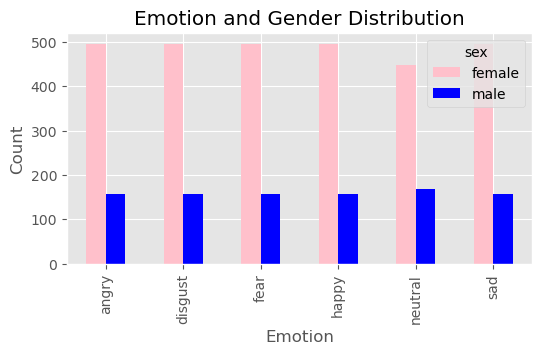

In [9]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(df)

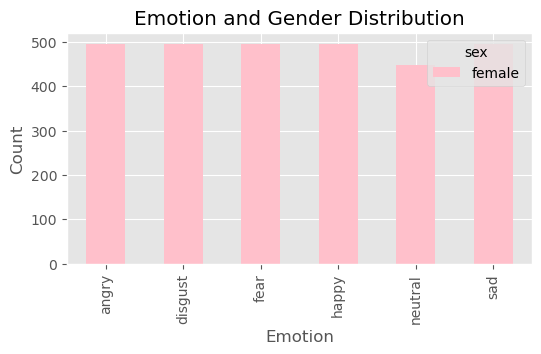

In [10]:
# I decided to go with a female specific model 
df = df[df['sex'] == 'female']
plot_distribution(df)

In [11]:
df.drop('sex', axis=1, inplace=True)
df.head()

,path,emotion
44,./kaggle/input/ravdess-emotional-speech-audio/...,neutral
45,./kaggle/input/ravdess-emotional-speech-audio/...,neutral
46,./kaggle/input/ravdess-emotional-speech-audio/...,neutral
47,./kaggle/input/ravdess-emotional-speech-audio/...,neutral
48,./kaggle/input/ravdess-emotional-speech-audio/...,happy


In [12]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

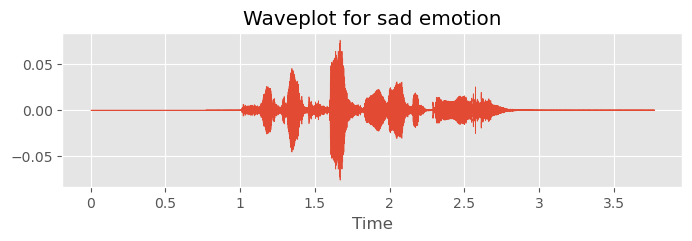

In [13]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

# 3. Preprocess

The following steps will be followed to preprocess the audio: 

1. Get an array of samples
2. Trim the silence  
3. Padding for equal length

In [14]:
from pydub import AudioSegment, effects

C:\Users\shrey\anaconda3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [15]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [16]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

# 4. Extract features

We will only extract these features: 

1. Mel-Frequency Cepstral Coefficients: captures the shape of the spectral envelope of a signal
2. Zero Crossing Rate: captures the number of times a signal changes sign per second
3. Root Mean Square Energy: captures the root mean square amplitude of the audio signal

In [17]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: ./kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


C:\Users\shrey\anaconda3\Lib\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


Failed for path: ./kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_angry/YAF_germ_angry.wav
Failed for path: ./kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_neat_fear.wav


In [18]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

# 5. Build a LSTM

Before building the model, we will have to setup the data. LSTM are great for sequences.  

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [20]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [21]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [22]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

C:\Users\shrey\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 352, 64)             │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,894 (210.52 KB)

 Trainable params: 53,894 (210.52 KB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=200, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - categorical_accuracy: 0.2550 - loss: 1.6811 - val_categorical_accuracy: 0.3102 - val_loss: 1.5928
Epoch 2/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - categorical_accuracy: 0.3878 - loss: 1.4183 - val_categorical_accuracy: 0.3592 - val_loss: 1.2942
Epoch 3/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - categorical_accuracy: 0.4778 - loss: 1.2300 - val_categorical_accuracy: 0.4857 - val_loss: 1.2077
Epoch 4/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - categorical_accuracy: 0.5091 - loss: 1.1897 - val_categorical_accuracy: 0.3633 - val_loss: 1.6635
Epoch 5/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - categorical_accuracy: 0.5865 - loss: 1.0502 - val_categorical_accuracy: 0.6204 - val_loss: 0.9750
Epoch 6/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - categorical_accuracy: 0.6274 - loss: 0.9719 - val_categorical_accuracy: 0.6735 - val_loss: 0.8862
Epoch 7/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - categorical_a

429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - categorical_accuracy: 0.8438 - loss: 0.4607 - val_categorical_accuracy: 0.8408 - val_loss: 0.4847
Epoch 45/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - categorical_accuracy: 0.8553 - loss: 0.4072 - val_categorical_accuracy: 0.8531 - val_loss: 0.4358
Epoch 46/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - categorical_accuracy: 0.8608 - loss: 0.4056 - val_categorical_accuracy: 0.8449 - val_loss: 0.4497
Epoch 47/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - categorical_accuracy: 0.8557 - loss: 0.3977 - val_categorical_accuracy: 0.8163 - val_loss: 0.4737
Epoch 48/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - categorical_accuracy: 0.8608 - loss: 0.3926 - val_categorical_accuracy: 0.7918 - val_loss: 0.6497
Epoch 49/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - categorical_accuracy: 0.8690 - loss: 0.3741 - val_categorical_accuracy: 0.8490 - val_loss: 0.4508
Epoch 50/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - categorical_accurac

429/429 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - categorical_accuracy: 0.8847 - loss: 0.3575 - val_categorical_accuracy: 0.8735 - val_loss: 0.3703
Epoch 88/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - categorical_accuracy: 0.9068 - loss: 0.2830 - val_categorical_accuracy: 0.8367 - val_loss: 0.4418
Epoch 89/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - categorical_accuracy: 0.8877 - loss: 0.3265 - val_categorical_accuracy: 0.9143 - val_loss: 0.3662
Epoch 90/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - categorical_accuracy: 0.8975 - loss: 0.3146 - val_categorical_accuracy: 0.8571 - val_loss: 0.4152
Epoch 91/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - categorical_accuracy: 0.8913 - loss: 0.3217 - val_categorical_accuracy: 0.8857 - val_loss: 0.3708
Epoch 92/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - categorical_accuracy: 0.9100 - loss: 0.2740 - val_categorical_accuracy: 0.8327 - val_loss: 0.4084
Epoch 93/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - categorical_accurac

429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - categorical_accuracy: 0.9159 - loss: 0.2617 - val_categorical_accuracy: 0.9143 - val_loss: 0.2938
Epoch 131/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - categorical_accuracy: 0.9334 - loss: 0.2128 - val_categorical_accuracy: 0.9143 - val_loss: 0.2690
Epoch 132/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - categorical_accuracy: 0.9347 - loss: 0.1741 - val_categorical_accuracy: 0.9020 - val_loss: 0.3071
Epoch 133/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - categorical_accuracy: 0.9333 - loss: 0.2278 - val_categorical_accuracy: 0.9102 - val_loss: 0.2612
Epoch 134/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - categorical_accuracy: 0.9412 - loss: 0.1713 - val_categorical_accuracy: 0.9184 - val_loss: 0.2281
Epoch 135/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - categorical_accuracy: 0.9340 - loss: 0.1889 - val_categorical_accuracy: 0.8898 - val_loss: 0.3402
Epoch 136/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - categorical_a

Epoch 173/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - categorical_accuracy: 0.9561 - loss: 0.1557 - val_categorical_accuracy: 0.9306 - val_loss: 0.2085
Epoch 174/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - categorical_accuracy: 0.9607 - loss: 0.1252 - val_categorical_accuracy: 0.9265 - val_loss: 0.2733
Epoch 175/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - categorical_accuracy: 0.9549 - loss: 0.1558 - val_categorical_accuracy: 0.9429 - val_loss: 0.2067
Epoch 176/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - categorical_accuracy: 0.9579 - loss: 0.1277 - val_categorical_accuracy: 0.9265 - val_loss: 0.2419
Epoch 177/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - categorical_accuracy: 0.9612 - loss: 0.1196 - val_categorical_accuracy: 0.9265 - val_loss: 0.2490
Epoch 178/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - categorical_accuracy: 0.9538 - loss: 0.1313 - val_categorical_accuracy: 0.9306 - val_loss: 0.2692
Epoch 179/200
429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step -

# 6. Evaluate and conclude

Let's see how good are model is. 

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
MODEL.save('speech_emotion.h5')

In [31]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model('speech_emotion.h5')

# Evaluate the model on the test dataset
y_pred = loaded_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = tf.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_labels, y_test), tf.float32))

print("Test Accuracy:", accuracy.numpy())

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
Test Accuracy: 0.17906728


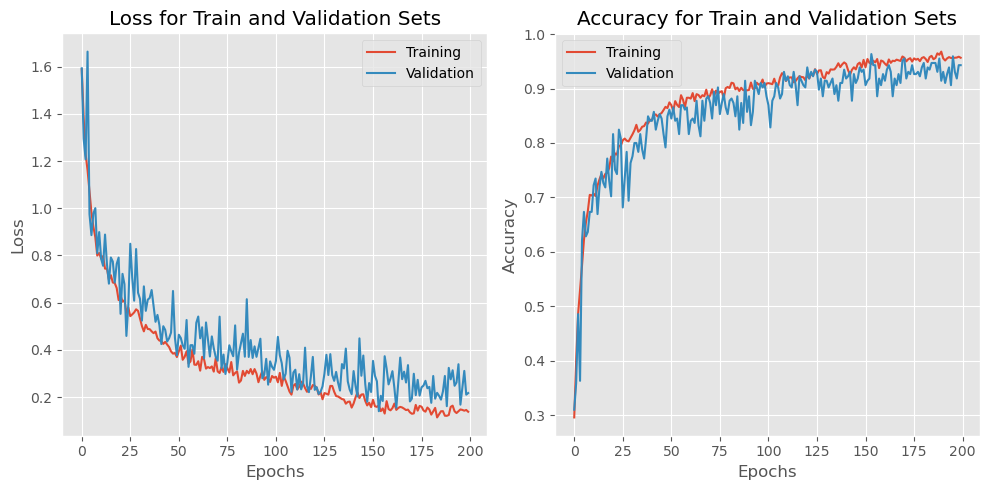

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


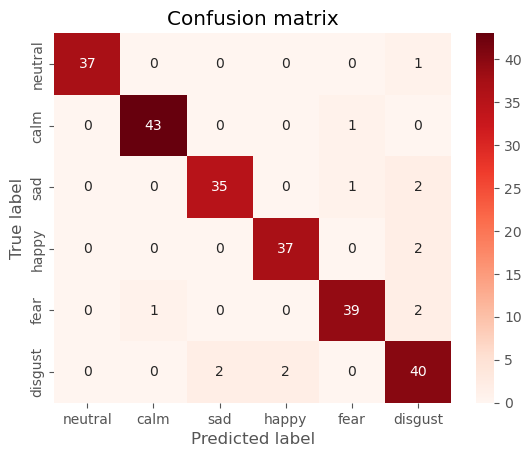

In [33]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

**Conclusion**

In summary, our model achieved 90% accuracy in classifying six different emotions. However, there are several ways we could improve it. For example, we could change the model, obtain a better dataset and extract different features. One optimization that we could make is to generate a codebook and apply vector quantization to reduce the dimensionality. This can help to improve the model's training speed and reduce the risk of overfitting. Lastly, don't forget to use accelerators to speed up the training process. 